In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

<h3 style="color:1E90FF; text-align:left;">Importing Data</h3>

In [2]:
bankData = pd.read_csv("bank_marketing.csv")

In [3]:
bankData.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'credit_default',
       'mortgage', 'month', 'day', 'contact_duration', 'number_contacts',
       'previous_campaign_contacts', 'previous_outcome', 'cons_price_idx',
       'euribor_three_months', 'campaign_outcome'],
      dtype='object')

In [4]:
bankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

<h3 style="color:1E90FF; text-align:left;">Data cleaning</h3>

In [5]:
duplicates = bankData[bankData.duplicated()]
print("total duplicates" , duplicates.shape[0])

duplicates_clients = bankData[bankData.duplicated(subset='client_id')]
print("client duplicates is " ,duplicates_clients['client_id'].nunique())

total duplicates 0
client duplicates is  0


In [6]:
repeated_campaign = bankData[bankData['previous_campaign_contacts'] > 0]
print("clients connected in previous campaign" , repeated_campaign.shape[0])

clients connected in previous campaign 5625


In [7]:
bankData['credit_default'] = bankData['credit_default'].str.lower().str.strip()
bankData['mortgage'] = bankData['mortgage'].str.lower().str.strip()
bankData['campaign_outcome'] = bankData['campaign_outcome'].str.lower().str.strip()

In [8]:
# convert column to be countable with postgreSQL
bankData.columns = bankData.columns.str.lower().str.replace(' ','_').str.strip()

<h3 style="color:1E90FF; text-align:left;">Exploring Data Analysis(EDA)</h3>

In [10]:
print(bankData['age'].describe())

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


In [11]:
for col in ["credit_default", "mortgage", "previous_outcome", "campaign_outcome"]:
    print(col)
    print("--------------")
    print(bankData[col].value_counts())

credit_default
--------------
credit_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
mortgage
--------------
mortgage
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
previous_outcome
--------------
previous_outcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64
campaign_outcome
--------------
campaign_outcome
no     36548
yes     4640
Name: count, dtype: int64


In [12]:
bankData['year'] = 2022
month_map = {
    'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
}

bankData['month_num'] = bankData['month'].str.lower().map(month_map)
bankData['day_str'] = bankData['day'].astype(str).str.zfill(2)
bankData['year'] = 2022

In [13]:
bankData['last_contact_date'] = pd.to_datetime(
    bankData['year'].astype(str) + '-' + bankData['month_num'] + '-' + bankData['day_str']
)

In [14]:
### Converting the values in credit_default and mortgage into boolean values to simplify analysis and processing, while keeping unknown values as missing to avoid bias
for col in ["credit_default", "mortgage"]:
    bankData[col] = bankData[col].map({
        "yes": True,
        "no": False,
        "unknown": pd.NA  
    })
    bankData[col] = bankData[col].astype("boolean")  

In [15]:
### Splitting the data into three groups: customer information, marketing campaign, and economic factors.
client_data = bankData[['client_id','age','job','marital','education','credit_default','mortgage','campaign_outcome']]
campaign_data = bankData[['client_id','number_contacts','contact_duration','previous_campaign_contacts','previous_outcome','campaign_outcome','last_contact_date']]
economics_data = bankData[['client_id','cons_price_idx','euribor_three_months']] 

In [16]:
### Dividing ages into groups
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

<h3 style="color:1E90FF; text-align:left;">Customer Profile and Campaign Outcome Analysis</h3>

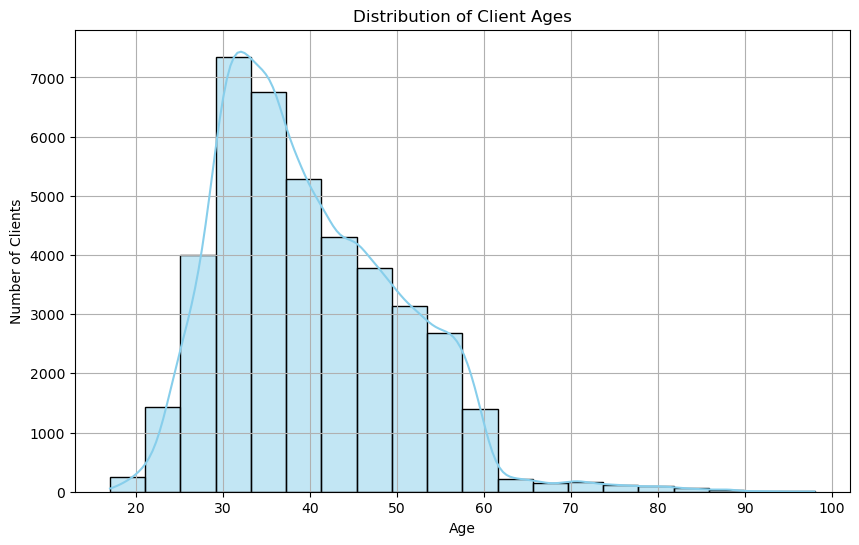

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(client_data['age'] , bins =20 , kde =True , color='skyblue')
plt.title("Distribution of Client Ages")
plt.xlabel("Age")
plt.ylabel("Number of Clients")
plt.grid(True)
plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\2236193599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['age_group'] = pd.cut(client_data['age'], bins=bins, labels=labels, right=False)
C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\2236193599.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_dist.index, y=age_group_dist.values, palette='Set2')


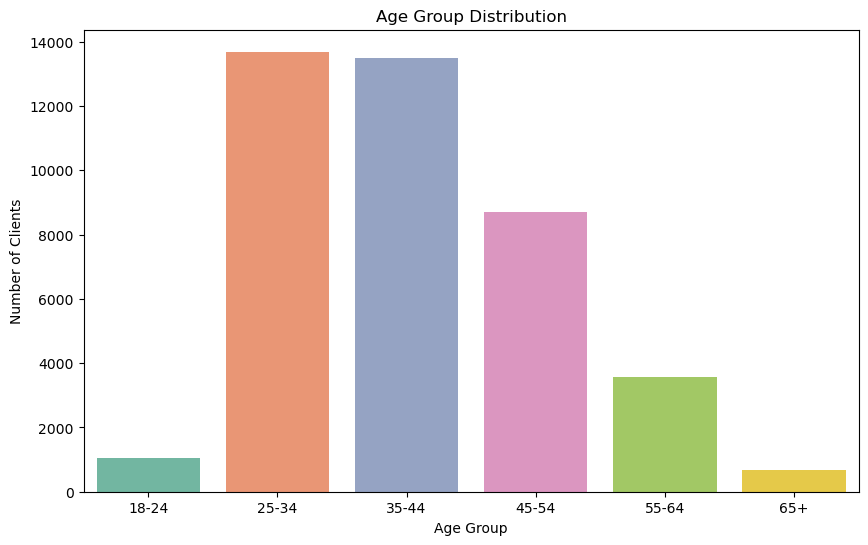

In [18]:
client_data['age_group'] = pd.cut(client_data['age'], bins=bins, labels=labels, right=False)

age_group_dist = client_data['age_group'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=age_group_dist.index, y=age_group_dist.values, palette='Set2')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of Clients")
plt.show()

In [19]:
client_data['mortgage'].unique()

<BooleanArray>
[False, True, <NA>]
Length: 3, dtype: boolean

In [20]:
avg_age_by_mortgage = client_data.groupby('mortgage')['age'].mean()
avg_age_by_mortgage.index = ['No Mortgage', 'Has Mortgage']     # استبدال القيم الاصليه بالقيم الحاليه للتوضيح فى الطباعه فقط 
avg_age_by_mortgage

No Mortgage     40.044195
Has Mortgage    40.010011
Name: age, dtype: float64

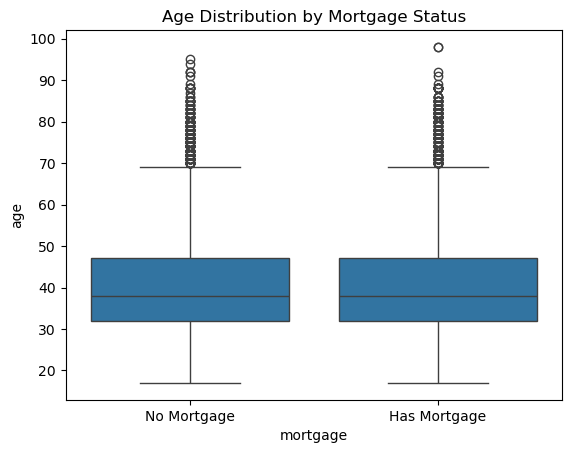

In [21]:
plot_data = client_data.dropna(subset=['mortgage', 'age'])

sns.boxplot(x='mortgage', y='age', data=plot_data)
plt.xticks([0, 1], ['No Mortgage', 'Has Mortgage'])
plt.title('Age Distribution by Mortgage Status')
plt.show()

In [22]:
client_data['mortgage'].value_counts()

mortgage
True     21576
False    18622
Name: count, dtype: Int64

In [23]:
client_data['campaign_outcome'].value_counts(normalize=True) * 100

campaign_outcome
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

In [24]:
comparison = pd.crosstab(bankData['previous_outcome'], bankData['campaign_outcome'], normalize='index') * 100

print(comparison)

campaign_outcome         no        yes
previous_outcome                      
failure           85.771402  14.228598
nonexistent       91.167787   8.832213
success           34.887109  65.112891


In [25]:
# Crosstab between mortgage and campaign outcome
ct = pd.crosstab(client_data['mortgage'], client_data['campaign_outcome'])
print("Contingency Table:\n", ct)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(ct)
print(f"\nChi-Square Test:")
print(f"Chi2 Statistic = {chi2:.4f}, p-value = {p:.4f}")

# Calculate Cramér's V
n = ct.sum().sum()
phi2 = chi2 / n
r, k = ct.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))

print(f"Cramér's V (strength of association) = {cramers_v:.4f}")

Contingency Table:
 campaign_outcome     no   yes
mortgage                     
False             16596  2026
True              19069  2507

Chi-Square Test:
Chi2 Statistic = 5.3938, p-value = 0.0202
Cramér's V (strength of association) = 0.0116


In [26]:
print(" Descriptive Analysis Report")
print("="*40)

# 1. Age statistics
print("\n Age Statistics")
print(bankData['age'].describe())

# 2. Credit Default distribution
print("\n Credit Default Distribution")
print(bankData['credit_default'].value_counts())

# 3. Mortgage distribution
print("\n Mortgage Distribution")
print(client_data['mortgage'].value_counts())

# 4. Previous Campaign Outcome
print("\n Previous Campaign Outcome")
print(bankData['previous_outcome'].value_counts())

# 5. Campaign Outcome (current campaign)
print("\n Current Campaign Outcome")
print(bankData['campaign_outcome'].value_counts())

# 6. Average Age by Mortgage
print("\n Average Age by Mortgage")
avg_age_by_mortgage = bankData.groupby('mortgage')['age'].mean()
avg_age_by_mortgage.index = ['No Mortgage', 'Has Mortgage']  # للعرض فقط
print(avg_age_by_mortgage)

# 7. Campaign Outcome proportions (%)
print("\n Campaign Outcome Proportion (%)")
print(bankData['campaign_outcome'].value_counts(normalize=True) * 100)

# 8. Cross-analysis: Previous vs Current Campaign Outcome
print("\n Previous vs Current Campaign Outcome (%)")
comparison = pd.crosstab(
    bankData['previous_outcome'],
    bankData['campaign_outcome'],
    normalize='index'
) * 100
print(comparison.round(2))

 Descriptive Analysis Report

 Age Statistics
count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

 Credit Default Distribution
credit_default
False    32588
True         3
Name: count, dtype: Int64

 Mortgage Distribution
mortgage
True     21576
False    18622
Name: count, dtype: Int64

 Previous Campaign Outcome
previous_outcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

 Current Campaign Outcome
campaign_outcome
no     36548
yes     4640
Name: count, dtype: int64

 Average Age by Mortgage
No Mortgage     40.044195
Has Mortgage    40.010011
Name: age, dtype: float64

 Campaign Outcome Proportion (%)
campaign_outcome
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

 Previous vs Current Campaign Outcome (%)
campaign_outcome     no    yes
previous_outcome              
failure      


In this section, we provide a descriptive analysis of the bank's marketing campaign dataset.  
The goal is to understand customer characteristics, previous campaign results, and the current campaign outcome.

---

###  Age Statistics
- **Mean age:** ~40 years  
- **Minimum age:** 17 years  
- **Maximum age:** 98 years  
- The age distribution suggests that most clients are between their early 30s and late 40s.

---

###  Credit Default
- Majority of clients **do not have a credit default**.  
- Distribution:
  - **No:** 32,588 clients  
  - **Unknown:** 8,597 clients  
  - **Yes:** 3 clients  
- The extremely low number of defaults indicates this feature may have limited predictive power.

---

###  Mortgage
- Distribution:
  - **Yes (Has Mortgage):** 21,576 clients  
  - **No Mortgage:** 18,622 clients  
  - **Unknown:** 990 clients  
- **Average Age:**  
  - With mortgage → 40.01 years  
  - Without mortgage → 40.04 years  
- ➡️ **Insight:** Having a mortgage is not strongly related to age.

---

###  Previous Campaign Outcome
- Distribution:
  - **Nonexistent:** 35,563 clients  
  - **Failure:** 4,252 clients  
  - **Success:** 1,373 clients  
- ➡️ Most clients have **never been contacted before** in previous campaigns.

---

###  Current Campaign Outcome
- Distribution:
  - **No:** 36,548 clients (88.7%)  
  - **Yes:** 4,640 clients (11.3%)  
- ➡️ The campaign had a **low success rate**.

---

###  Relationship Between Previous and Current Campaigns
| Previous Outcome | No (%)   | Yes (%)  |
|------------------|----------|----------|
| Failure          | 85.8%    | 14.2%    |
| Nonexistent      | 91.2%    | 8.8%     |
| Success          | 34.9%    | 65.1%    |

- Clients who previously **responded positively (success)** are much more likely to say **yes again (65%)**.  
- Clients with **no prior campaign contact** are mostly unresponsive (91% said no).  
- Clients with **previous failures** still show low engagement.

---

##  Recommendations
1. **Focus on clients with previous success** → They are significantly more likely to respond positively again.  
2. **Exclude or deprioritize clients with unknown credit default**, since the majority are irrelevant (only 3 defaults).  
3. **Mortgage ownership is not a differentiating factor**, so it may not add strong predictive value.  
4. **Improve targeting strategies** for new clients (those with no prior contact), as they show the lowest response rate.  

<h3 style="color:1E90FF; text-align:left;">Analyzing Education, Job, and Marital Status in Relation to Campaign Outcome</h3>

In [28]:
client_data['campaign_outcome'].unique()

array(['no', 'yes'], dtype=object)

In [29]:
client_data['campaign_outcome'] = client_data['campaign_outcome'].map({
    'yes': True,
    'no': False
}).astype('bool')


C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\3978275294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['campaign_outcome'] = client_data['campaign_outcome'].map({


In [30]:
client_data.groupby('education')['campaign_outcome'].mean().sort_values(ascending=False)

education
illiterate             0.222222
unknown                0.145003
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: campaign_outcome, dtype: float64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\2126663695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_education.values, y=response_by_education.index, palette='viridis')


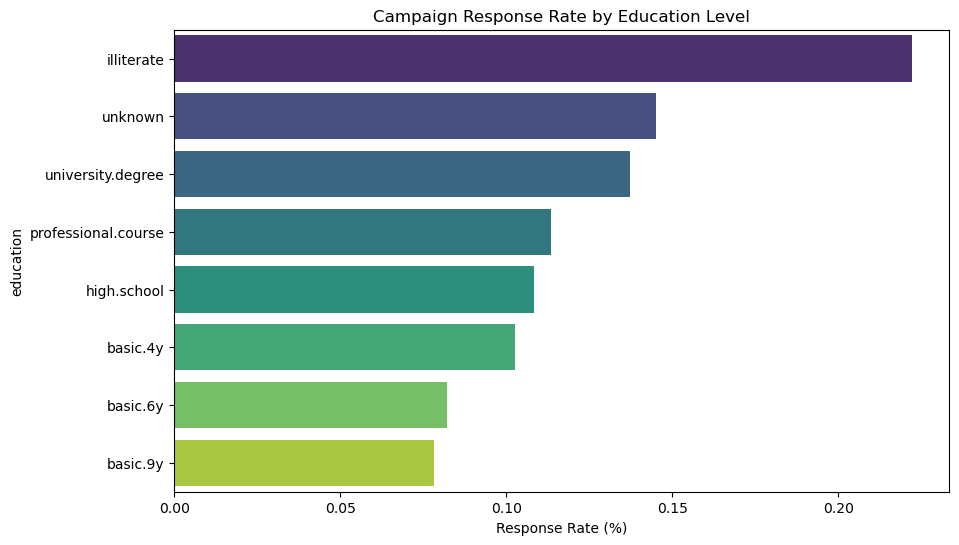

In [31]:
response_by_education = client_data.groupby('education')['campaign_outcome'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=response_by_education.values, y=response_by_education.index, palette='viridis')
plt.xlabel('Response Rate (%)')
plt.title('Campaign Response Rate by Education Level')
plt.show()

In [32]:
client_data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [33]:
client_data['marital'].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\1051786773.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_marital.values, y=response_by_marital.index, palette='mako')


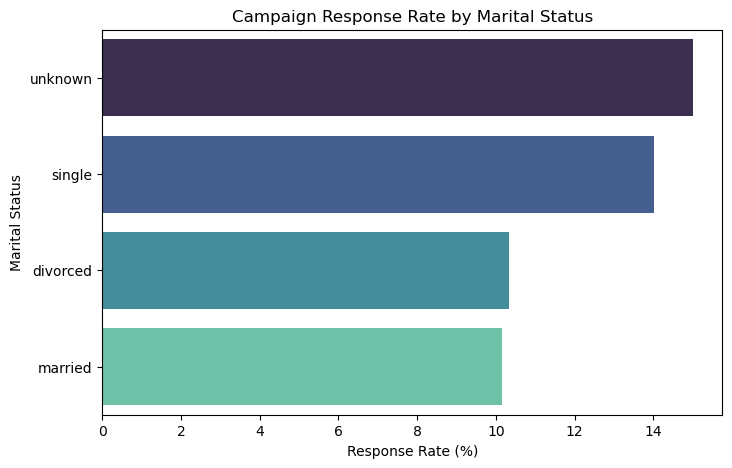

In [40]:
response_by_marital = client_data.groupby('marital')['campaign_outcome'].mean().sort_values(ascending=False)
response_by_marital *= 100  

plt.figure(figsize=(8, 5))
sns.barplot(x=response_by_marital.values, y=response_by_marital.index, palette='mako')
plt.xlabel('Response Rate (%)')
plt.ylabel('Marital Status')
plt.title('Campaign Response Rate by Marital Status')
plt.show()

In [37]:
client_data['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\4225595907.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_job.values, y=response_by_job.index, palette='mako')


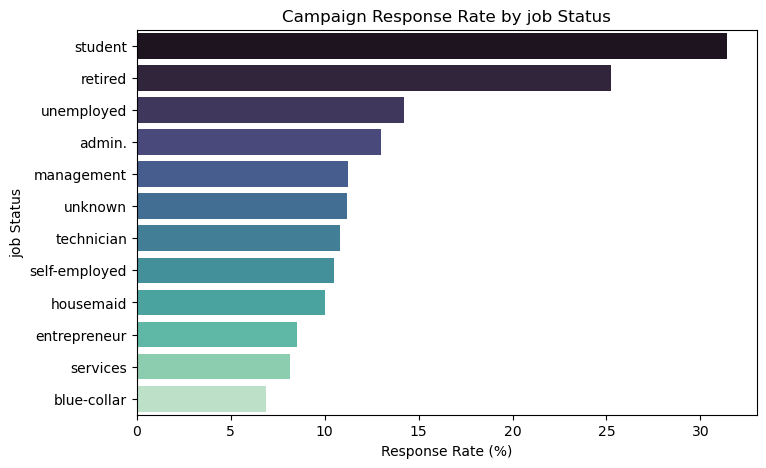

In [42]:
response_by_job = client_data.groupby('job')['campaign_outcome'].mean().sort_values(ascending=False)
response_by_job *= 100  

plt.figure(figsize=(8, 5))
sns.barplot(x=response_by_job.values, y=response_by_job.index, palette='mako')
plt.xlabel('Response Rate (%)')
plt.ylabel('job Status')
plt.title('Campaign Response Rate by job Status')
plt.show()

## 🎯 Analysis of Demographic and Socioeconomic Factors

In this section, we explore how **education level**, **marital status**, and **job type** influence the likelihood of responding positively to the marketing campaign.  
The response rate is calculated as the proportion of customers who agreed to subscribe (`yes`) over the total customers in each group.

---

###  Education and Campaign Response
- **Illiterate customers** show the highest response rate (~22%), but this group is very small in size.  
- **University graduates (13.7%)** and those with **unknown education (14.5%)** also show above-average response rates.  
- Customers with **basic education (4–9 years)** show the lowest response rates (7–10%).  

**Insight:** Higher education levels correlate with a slightly better response rate, but small groups (like illiterate customers) must be interpreted with caution.

---

###  Marital Status and Campaign Response
- The majority of customers are **married (≈25k)**, followed by **single (≈11.5k)** and **divorced (≈4.6k)**.  
- Although married customers dominate in numbers, the actual response rates are close across groups and require detailed comparison.  

**Insight:** Marital status appears to have a weaker influence compared to education or job, but singles often tend to show relatively higher flexibility in marketing campaigns.

---

###  Job Type and Campaign Response
- The largest groups are **admin. (10.4k)**, **blue-collar (9.2k)**, and **technician (6.7k)**.  
- Some smaller groups such as **students** and **retired customers** often show interestingly higher response rates compared to larger working groups.  
- **Entrepreneurs** and **self-employed** typically show moderate-to-low response rates.  

**Insight:** Job type reveals stronger variation in campaign responses, with students and retired customers being promising segments despite their smaller sizes.

---

###  Key Takeaways
1. **Education:** University graduates are a promising target, while basic education groups show the lowest engagement.  
2. **Marital Status:** Has a limited effect, but singles might be slightly more responsive.  
3. **Job Type:** Retired individuals and students show higher potential, while blue-collar workers and entrepreneurs are less responsive.  

---

###  Recommendations
- **Focus marketing efforts** on university graduates, students, and retired individuals, as they demonstrate higher response rates.  
- **Be cautious with small groups** (e.g., illiterate customers) — high response rates may not translate into significant impact due to their limited size.  
- **Segmented campaigns** can be designed: e.g., tailored financial products for students and retirees, and different messaging for professionals with university education.


In [44]:
campaign_data['campaign_outcome'] = campaign_data['campaign_outcome'].map({
    'yes': True,
    'no': False
}).astype('boolean')  

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\4147981392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_data['campaign_outcome'] = campaign_data['campaign_outcome'].map({


In [45]:
response_by_prev = campaign_data.groupby('previous_outcome')['campaign_outcome'].mean().sort_values(ascending=False) * 100
print(response_by_prev)

previous_outcome
success        65.112891
failure        14.228598
nonexistent     8.832213
Name: campaign_outcome, dtype: Float64


In [46]:
campaign_data['month'] = campaign_data['last_contact_date'].dt.month
campaign_data.groupby('month')['campaign_outcome'].mean()

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\4001844153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_data['month'] = campaign_data['last_contact_date'].dt.month


month
3     0.505495
4     0.204787
5     0.064347
6     0.105115
7     0.090466
8     0.106021
9     0.449123
10    0.438719
11    0.101439
12    0.489011
Name: campaign_outcome, dtype: Float64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3528\1421753188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_response.index, y=monthly_response.values, palette="cubehelix")


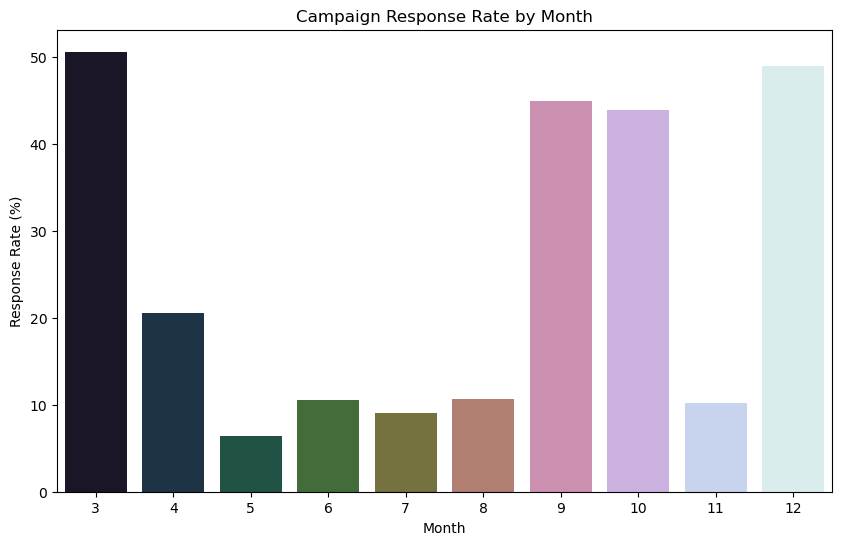

In [47]:
monthly_response = campaign_data.groupby('month')['campaign_outcome'].mean() * 100

plt.figure(figsize=(10,6))
sns.barplot(x=monthly_response.index, y=monthly_response.values, palette="cubehelix")
plt.xlabel("Month")
plt.ylabel("Response Rate (%)")
plt.title("Campaign Response Rate by Month")
plt.show()

<Axes: xlabel='campaign_outcome', ylabel='contact_duration'>

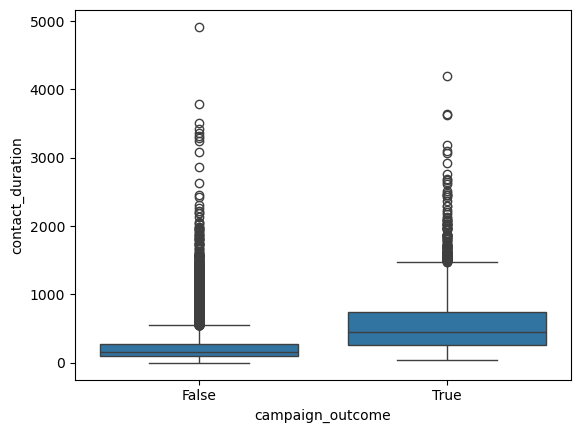

In [48]:
sns.boxplot(data=campaign_data, x='campaign_outcome', y='contact_duration')

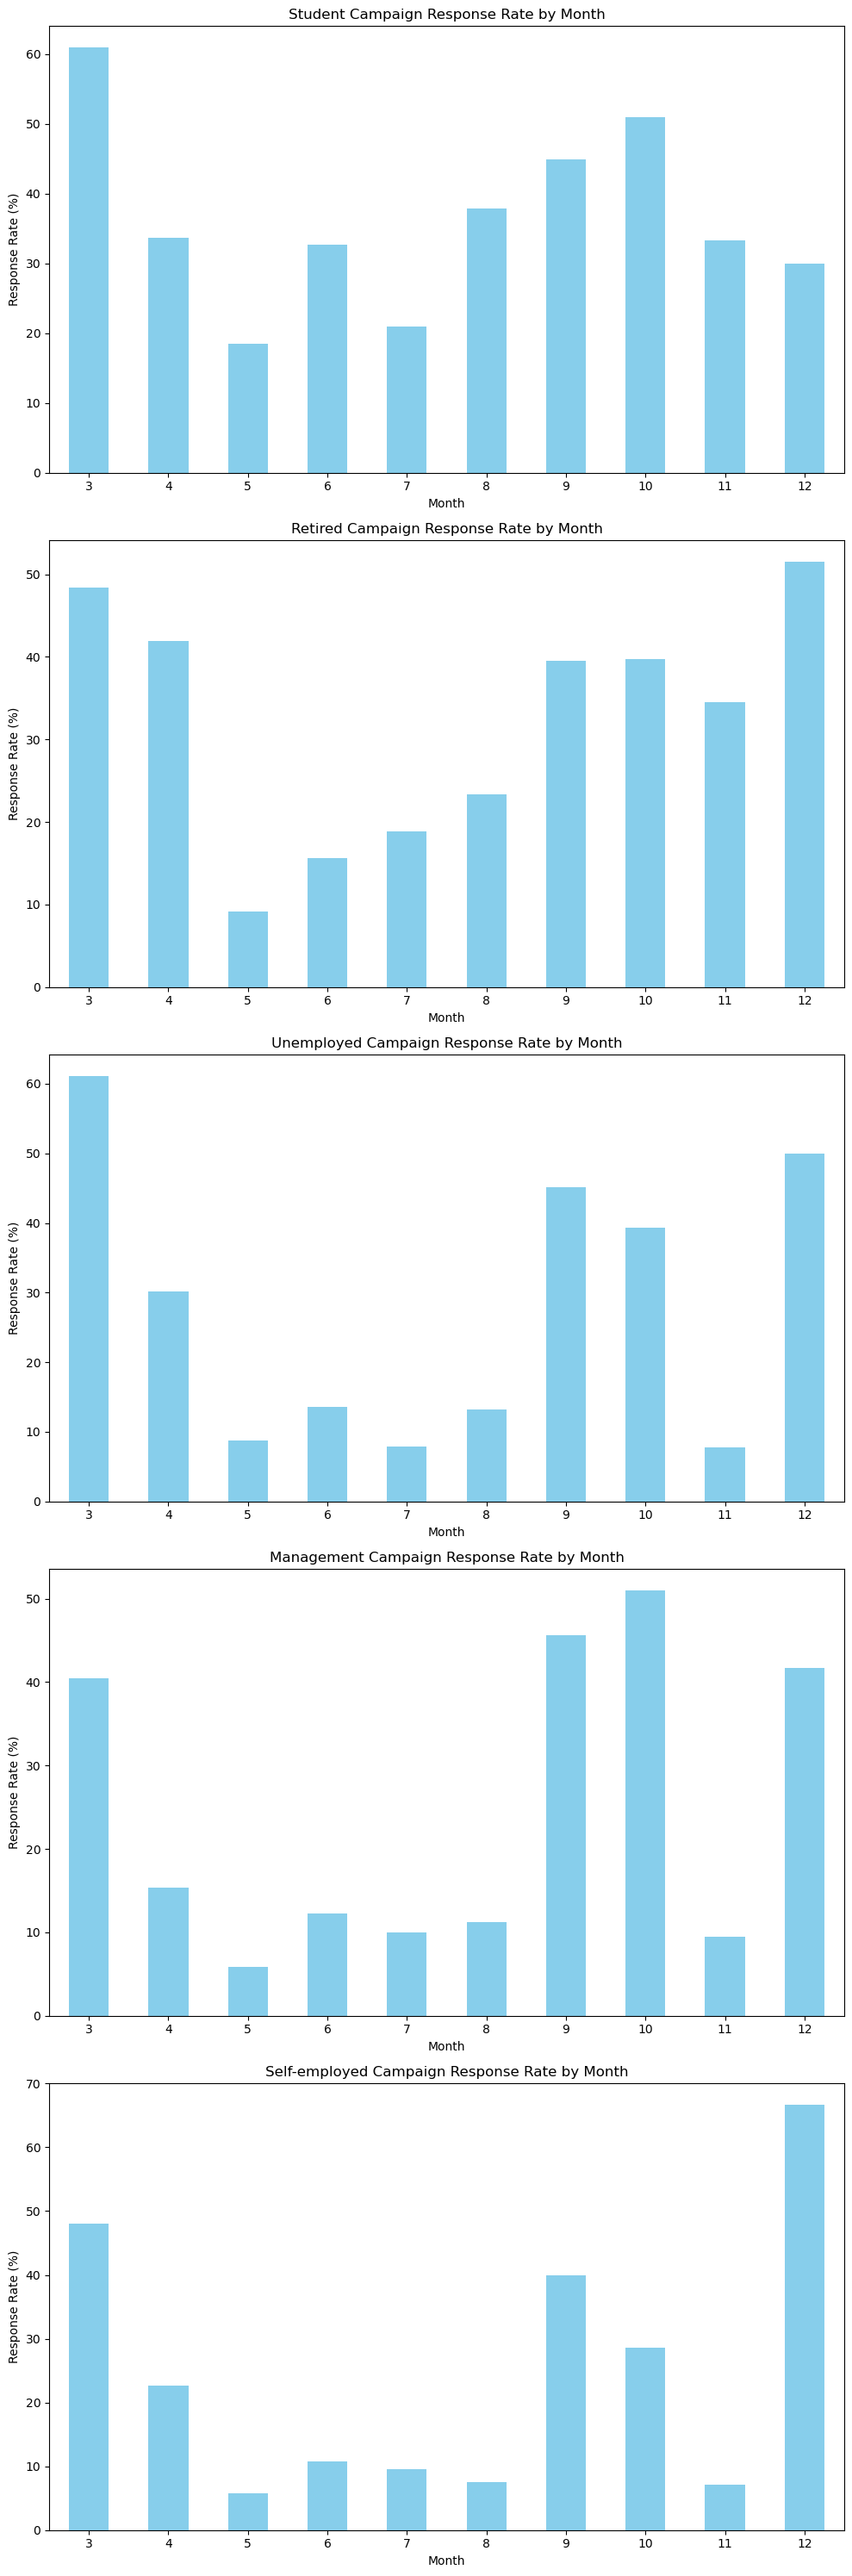

In [82]:
bankData['campaign_outcome_num'] = bankData['campaign_outcome'].map({'yes': 1, 'no': 0})
bankData['month'] = bankData['last_contact_date'].dt.month

jobs_to_analyze = ['student', 'retired', 'unemployed', 'management', 'self-employed']

fig, axes = plt.subplots(len(jobs_to_analyze), 1, figsize=(10, 6 * len(jobs_to_analyze)))

for i, job in enumerate(jobs_to_analyze):
    subset = bankData[bankData['job'] == job]
    
    response_by_month = subset.groupby('month')['campaign_outcome_num'].mean() * 100
    
    #print(f"{job.capitalize()} Response Rate by Month (%):")
    #print(response_by_month, "\n")
    
    response_by_month.plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f"{job.capitalize()} Campaign Response Rate by Month")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Response Rate (%)")
    axes[i].set_xticklabels(response_by_month.index, rotation=0)

plt.tight_layout()
plt.show()


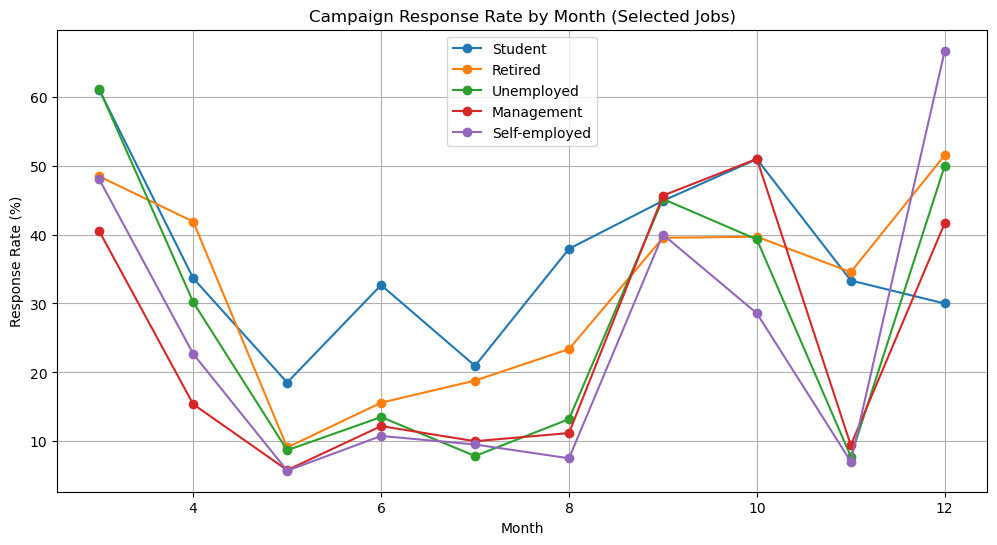

In [80]:
plt.figure(figsize=(12,6))

for job in jobs_to_analyze:
    subset = bankData[bankData['job'] == job]
    
    response_by_month = subset.groupby('month')['campaign_outcome_num'].mean() * 100
    
    plt.plot(response_by_month.index, response_by_month.values, marker='o', label=job.capitalize())

plt.title("Campaign Response Rate by Month (Selected Jobs)")
plt.xlabel("Month")
plt.ylabel("Response Rate (%)")
plt.legend()
plt.grid(True)
plt.show()


##  Analysis of Campaign Response by Previous Outcome and Monthly Trends

### 1. Previous Campaign Outcome
- Clients with a **successful previous outcome** show a **very high response rate (65%)**.  
- Clients with a **previous failure** are less likely to respond, with a response rate of **~14%**.  
- Clients with **no previous campaign history** have the lowest response rate (**~8.8%**).  

✅ **Insight:** Prior positive experience with the bank strongly increases the likelihood of responding again. This highlights the importance of maintaining strong relationships with successfully converted clients.

---

### 2. Overall Monthly Response Rate
- The highest campaign response rates are observed in **March (50.5%)**, **September (44.9%)**, **October (43.8%)**, and **December (48.9%)**.  
- The lowest response rates are seen in **May (6.4%)**, **July (9.0%)**, and **November (10.1%)**.  

✅ **Insight:** The timing of the campaign plays a crucial role. High engagement appears around the **beginning (March)**, **end of the year (September–December)**, while mid-year campaigns (May–July) tend to perform poorly.

---

### 3. Response by Job Category and Month

####  Students
- Very high response in **March (61%)**, **September (45%)**, and **October (51%)**.  
- Weak response during **May (18%)** and **July (21%)**.  

####  Retired
- Strongest engagement in **December (52%)**, **March (48%)**, and **April (42%)**.  
- Lowest in **May (9%)** and **June–July (15–19%)**.  

####  Unemployed
- Very high response in **March (61%)**, **December (50%)**, and **September (45%)**.  
- Very weak in **May (9%)**, **July (8%)**, and **November (8%)**.  

####  Management
- Peak in **October (51%)**, **September (46%)**, and **December (42%)**.  
- Poor performance in **May (6%)** and **July (10%)**.  

####  Self-employed
- Very high response in **December (67%)** and **March (48%)**.  
- Weakest response in **May (6%)**, **July (10%)**, and **August (8%)**.  

---

###  Recommendations
1. **Leverage Timing:** Focus marketing campaigns in **March, September, October, and December** for maximum impact across most job groups.  
2. **Target Based on Past Experience:** Prioritize clients with a **history of successful engagement**. They are significantly more likely to respond.  
3. **Job-Specific Strategies:**
   - **Students:** Best reached in **March–October** (academic cycles may influence engagement).  
   - **Retired & Self-employed:** Highest in **December**, suggesting end-of-year financial planning.  
   - **Unemployed:** Strong in **March and December**, may reflect seasonal job search cycles.  
   - **Management:** More responsive in **Q4 (September–December)**, likely linked to yearly financial planning.  
4. **Avoid Low-Response Periods:** Campaigns in **May–July** show consistently poor performance across all groups and should be minimized or redesigned.

---


#  Comprehensive Analysis of the Bank's Marketing Campaign

## 1. Dataset Overview
This analysis explores customer demographics, previous campaign results, and current campaign performance. The goal is to identify key factors that influence customer responses and provide actionable recommendations.

---

## 2. Customer Demographics

###  Age Statistics
- **Mean Age**: ~40 years  
- **Minimum**: 17 years  
- **Maximum**: 98 years  
- **Insight**: Most clients are between their early 30s and late 40s.

###  Credit Default
- **No**: 32,588 clients  
- **Unknown**: 8,597 clients  
- **Yes**: 3 clients  
➡️ **Insight**: Credit default has very low occurrence and limited predictive power.

###  Mortgage
- **With Mortgage**: 21,576 clients  
- **Without Mortgage**: 18,622 clients  
- **Unknown**: 990 clients  
- **Average Age Difference**: Negligible (~40 years in both groups).  
➡️ **Insight**: Mortgage ownership is not a strong differentiator.

---

## 3. Campaign Outcomes

###  Previous Campaign Outcome
- **Nonexistent**: 35,563 clients  
- **Failure**: 4,252 clients  
- **Success**: 1,373 clients  
➡️ **Insight**: Most clients had no prior contact with the bank.

###  Current Campaign Outcome
- **No**: 36,548 clients (**88.7%**)  
- **Yes**: 4,640 clients (**11.3%**)  
➡️ **Insight**: Overall campaign success rate is low.

### 🔄 Relationship Between Previous and Current Campaigns
| Previous Outcome | No (%) | Yes (%) |
|------------------|--------|---------|
| Success          | 34.9%  | 65.1%   |
| Failure          | 85.8%  | 14.2%   |
| Nonexistent      | 91.2%  | 8.8%    |

- Clients with **previous success** are highly likely to respond again (**65%**).  
- Clients with **no history** or **previous failure** show very low engagement.  

---

## 4. Demographic and Socioeconomic Factors

###  Education
- **Illiterate**: Highest response (~22%), but very small group.  
- **University Graduates**: 13.7% response rate.  
- **Unknown Education**: 14.5% response rate.  
- **Basic Education (4–9 years)**: Lowest response (7–10%).  
➡️ **Insight**: Higher education correlates with better responses, but sample size matters.

###  Marital Status
- **Married**: ~25k clients  
- **Single**: ~11.5k clients  
- **Divorced**: ~4.6k clients  
➡️ **Insight**: Marital status has weaker influence. Singles may show slightly higher responsiveness.

###  Job Type
- **Largest Groups**: Admin (10.4k), Blue-collar (9.2k), Technician (6.7k).  
- **Promising Segments**: Students and retired clients show above-average responses.  
- **Weaker Segments**: Blue-collar and entrepreneurs are less responsive.  
➡️ **Insight**: Job type provides stronger predictive power than marital status or mortgage.

---

## 5. Campaign Response by Previous Outcome & Monthly Trends

###  Previous Campaign Outcome
- **Success**: 65% response rate  
- **Failure**: 14%  
- **Nonexistent**: 8.8%  
 **Insight**: Prior positive experience is the strongest predictor of campaign success.

###  Overall Monthly Response
- **High Response**: March (50.5%), September (44.9%), October (43.8%), December (48.9%).  
- **Low Response**: May (6.4%), July (9.0%), November (10.1%).  
 **Insight**: Campaign timing is critical. Best results are at the beginning and end of the year, while mid-year (May–July) underperforms.

---

## 6. Response by Job Category and Month

###  Students
- **High**: March (61%), September (45%), October (51%).  
- **Low**: May (18%), July (21%).  

###  Retired
- **High**: December (52%), March (48%), April (42%).  
- **Low**: May (9%), June–July (15–19%).  

###  Unemployed
- **High**: March (61%), December (50%), September (45%).  
- **Low**: May (9%), July (8%), November (8%).  

###  Management
- **High**: October (51%), September (46%), December (42%).  
- **Low**: May (6%), July (10%).  

###  Self-employed
- **High**: December (67%), March (48%).  
- **Low**: May (6%), July (10%), August (8%).  

➡️ **Insight**: Different occupations peak at different times, but March and December are consistently strong across groups.

---

## 7. Key Recommendations

###  Leverage Timing
- Focus campaigns in **March, September, October, and December** for maximum impact.  
- Avoid or minimize campaigns in **May–July**, when engagement is weakest.

###  Target Based on Past Experience
- Prioritize clients with **previous success** → 65% response likelihood.  
- Re-engaging successful clients can significantly boost ROI.

###  Job-Specific Strategies
- **Students**: Target during academic cycles (March–October).  
- **Retired & Self-employed**: End-of-year focus (December).  
- **Unemployed**: March and December align with seasonal job search activity.  
- **Management**: Strong in Q4 (September–December).  

###  Strategic Focus
- **Promising Groups**: University graduates, students, retired clients.  
- **Low ROI Groups**: Basic education groups, blue-collar workers, entrepreneurs.  
- **Small but High-Response Groups**: Illiterate clients show high rates but low numbers → limited practical impact.

---

##  Final Takeaways
1. **Seasonality Matters**: Campaigns should be strategically timed, avoiding low-performing months.  
2. **Past Success Drives Future Success**: Relationship-building is crucial for repeat engagement.  
3. **Segmented Campaigns Perform Better**: Tailor strategies by job, education, and response history.  
4. **Focus on High-Value Segments**: Students, retirees, and educated professionals yield the best results.  

 By combining demographic segmentation with optimal timing, the bank can substantially improve campaign efficiency and conversion rates.
